# CLV model

[Customer value in non-contractual business model](https://towardsdatascience.com/whats-a-customer-worth-8daf183f8a4f)

[lifetimes python package](https://github.com/CamDavidsonPilon/lifetimes) for modeling customer lifetime value (CVL). [Docs](https://lifetimes.readthedocs.io/en/latest/index.html).

[CLV in pyspark](http://webdropin.com/wordpress99/customer-lifetime-value-in-pyspark/)

[CLV broken down step-by-step](http://benalexkeen.com/bg-nbd-model-for-customer-base-analysis-in-python/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from lifetimes import BetaGeoFitter

from lifetimes.plotting import plot_frequency_recency_matrix

import helper as h

In [2]:
analysis_year = '2017'
user_data_2017 = h.get_merged_data(appName='CVL-model', year=analysis_year)
user_data_2017 = user_data_2017.select(user_data_2017.login,
                                       user_data_2017.first_event,
                                       user_data_2017.last_event,
                                       user_data_2017.frequency,
                                       user_data_2017.second_period_event_count)

Threshold events N: 600
% of users dropped 2.96


'user_data = user_data_2017.select(user_data_2017.login,\n                                       user_data_2017.first_event,\n                                       user_data_2017.last_event,\n                                       user_data_2017.frequency,\n                                       user_data_2017.second_period_event_count)'

In [3]:
user_data_2016 = h.get_merged_data(appName='CVL-model', year='2016')
user_data_2016 = user_data_2016.select(user_data_2016.login, 
                                       user_data_2016.created_at)
user_data_2016 = user_data_2016.withColumnRenamed('login', 'login2016')
user_data_2016.head()

Threshold events N: 200
% of users dropped 4.7


Row(login2016='0loky0', created_at=datetime.datetime(2011, 5, 24, 16, 15, 25))

In [4]:
user_data = user_data_2017.join(user_data_2016,
                                user_data_2017['login'] == user_data_2016['login2016'],
                                how='right_outer')

In [3]:
user_data = user_data.toPandas()

In [4]:
user_data[['frequency', 'second_period_event_count']] = user_data[['frequency', 'second_period_event_count']].fillna(0)
user_data[['first_event', 'last_event']] = user_data[['first_event', 'last_event']].fillna("2017-01-01 01:01:01")

In [5]:
user_data = h.add_time_columns(user_data, end_date=analysis_year + '-06-01 23:59:59')

In [6]:
user_data.head()

,login,followers_count,following_count,blog,company,created_at,public_repos_count,public_gists_count,hireable,recency,...,IssueCommentEvent_count,IssuesEvent_count,MemberEvent_count,PublicEvent_count,PullRequestEvent_count,PullRequestReviewCommentEvent_count,PushEvent_count,ReleaseEvent_count,WatchEvent_count,T
0,DigitalCowboy,0,0,0,0,2012-07-08 11:25:55-05:00,0.0,0.0,0,1645.093160,...,0,0,0,0,0,0,0,0,2,1789.0
1,FrancisWoo,0,0,0,0,2015-10-01 18:18:04-05:00,6.0,0.0,0,548.158727,...,0,0,0,0,3,0,4,0,2,609.0
2,HIPERCUBE,42,21,0,1,2014-04-28 00:21:35-05:00,43.0,7.0,1,1122.935718,...,0,0,0,0,0,0,6,0,12,1131.0
3,Mattl30,0,0,0,0,2017-02-06 08:00:50-06:00,0.0,0.0,0,0.248194,...,0,0,0,0,0,0,0,0,0,115.0
4,Morhwa,0,1,0,0,2015-06-14 18:53:46-05:00,2.0,0.0,0,717.093102,...,0,0,0,0,0,0,1,0,2,718.0


### T, recency and frequency

Definitions from [lifetime](https://lifetimes.readthedocs.io/en/latest/Quickstart.html):

`frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

`T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

`recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

### Model CLV

In [7]:
n_weeks =  22 

user_data['recency'] = np.floor(user_data.recency)
lifetime_df = user_data[['frequency', 'recency', 'T', 'login', 'second_period_event_count']]
# normalize frequency per week
#lifetime_df['frequency'] = lifetime_df.frequency / n_weeks
#lifetime_df['second_period_event_count'] = lifetime_df.second_period_event_count / n_weeks

lifetime_df = lifetime_df.dropna()

In [8]:
lifetime_df.head()

,frequency,recency,T,login,second_period_event_count
0,2,1645.0,1789.0,DigitalCowboy,0
1,15,548.0,609.0,FrancisWoo,0
2,21,1122.0,1131.0,HIPERCUBE,11
3,3,0.0,115.0,Mattl30,0
4,5,717.0,718.0,Morhwa,1


In [9]:
lifetime_df = lifetime_df[(lifetime_df["T"] >= 0)]
lifetime_df['recency'][lifetime_df.frequency == 0] = 0
lifetime_df = lifetime_df[lifetime_df["recency"] >= 0]
#lifetime_df = lifetime_df[lifetime_df.frequency > 0]

In [10]:
lifetime_df['recency'] /= 7
lifetime_df['T'] /= 7

In [11]:
lifetime_df.describe()

,frequency,recency,T,second_period_event_count
count,4570.000000,4570.000000,4570.000000,4570.000000
mean,27.036543,104.834354,111.664770,19.743982
std,50.095267,105.476312,104.362266,49.182809
min,2.000000,0.000000,0.142857,0.000000
25%,4.000000,10.000000,19.428571,0.000000
50%,9.000000,75.571429,82.285714,2.000000
75%,27.000000,170.392857,175.857143,17.000000
max,574.000000,480.714286,483.571429,573.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e9b9a1668>,
      dtype=object)

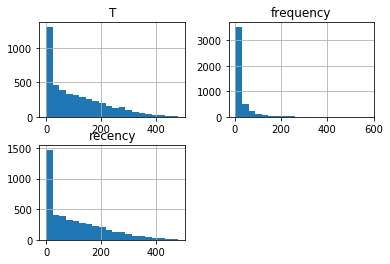

In [12]:
lifetime_df[['frequency', 'T', 'recency']].hist(bins=20)

In [13]:
# similar API to scikit-learn and lifelines.
n_users = len(lifetime_df)
lft_df = lifetime_df.sample(n=n_users, random_state=0)
bgf = BetaGeoFitter(penalizer_coef=1e-8)
bgf.fit(lft_df['frequency'], lft_df['recency'], lft_df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4570 subjects, a: 1.63, alpha: 0.00, b: 2.03, r: 0.06>


In [38]:
# save the model
bgf.save_model('CLV.pkl')

/home/brian/anaconda3/lib/python3.7/site-packages/lifetimes/fitters/beta_geo_fitter.py:214: RuntimeWarning: overflow encountered in double_scalars
  ((alpha + T) / (alpha + recency)) ** (r + x)


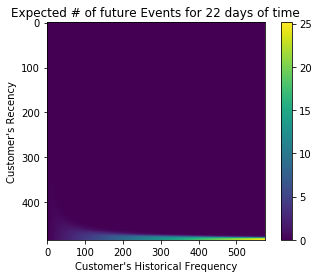

In [14]:
fig, ax = plt.subplots(1, 1)
ax = plot_frequency_recency_matrix(bgf, T=n_weeks, max_frequency=None, max_recency=None,
                             title='Expected # of future Events for {0} days of time'.format(n_weeks))
fig.savefig('figures/expected_number_events.png')

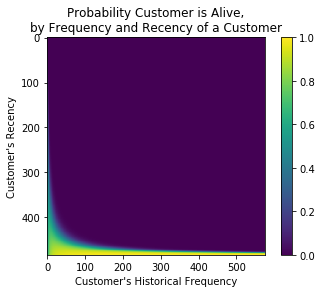

In [15]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

## Expected contributions in the upcoming cycle

In [16]:
lft_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(n_weeks,
                                                                                        lft_df['frequency'], 
                                                                                        lft_df['recency'], 
                                                                                        lft_df['T'])
lft_df.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,login,second_period_event_count,predicted_purchases
3484,268,38.857143,39.142857,Matt2694,105,100.254371
2992,359,58.285714,58.571429,ta1188,395,101.288185
2957,150,12.142857,12.285714,Rpetrill93,9,107.887694
3119,527,61.571429,62.000000,LitvinenkoIra,341,130.333034
1254,541,21.000000,21.142857,muhamarief,164,278.905788


[[1.         0.38967506]
 [0.38967506 1.        ]]


49.28413988723245

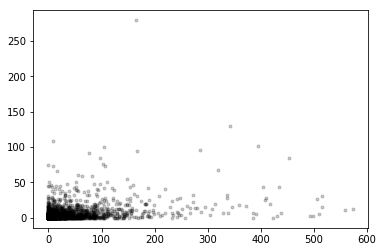

In [17]:
#user_data.dtypes
#predict_df = predict_df[predict_df.second_period_event_count < 60]
#lft_df['predicted_purchases'] = lft_df.predicted_purchases
plt.plot(lft_df.second_period_event_count, lft_df.predicted_purchases, 'k.', alpha=0.2)
#plt.xlim([0, 60])
#plt.ylim([0, 60])

print(np.corrcoef(lft_df.predicted_purchases, lft_df.second_period_event_count))
np.sqrt(np.mean((lft_df.predicted_purchases - lft_df.second_period_event_count) ** 2))

In [18]:
lft_df['probability_alive'] = bgf.conditional_probability_alive(1, lft_df['frequency'], 
                                                                  lft_df['recency'], n_weeks)
lft_df['alive'] = lft_df['probability_alive'] > 0.5
lft_df.head(15)

,frequency,recency,T,login,second_period_event_count,predicted_purchases,probability_alive,alive
3092,21,233.428571,247.000000,BrianBland,15,1.417549e+00,0.089202,False
1361,3,0.000000,17.285714,wavi220711,0,0.000000e+00,1.000000,True
4088,17,130.428571,135.428571,ahmedshaaban00,15,2.122129e+00,0.126558,False
3218,2,0.000000,3.571429,alptimucin,0,1.098327e-283,1.000000,True
4390,231,250.142857,253.428571,slightlyoffbeat,372,1.640697e+01,0.534143,True
3024,251,114.142857,114.285714,aquadrizzt,119,4.153395e+01,0.741423,True
2284,2,0.000000,15.571429,serkanpar,0,2.507013e-285,1.000000,True
2676,12,79.285714,81.000000,alexander-volodko-minsk,0,2.385556e+00,0.145065,False
3817,2,0.000000,0.285714,antoaneta840,0,3.267400e-281,1.000000,True
2611,2,121.285714,134.428571,rahmanuddin,0,1.888861e-01,0.016050,False


In [19]:
TP = np.sum((lft_df.alive == True) & (lft_df.second_period_event_count > 0))
FP = np.sum((lft_df.alive == False) & (lft_df.second_period_event_count > 0))
FN = np.sum((lft_df.alive == True) & (lft_df.second_period_event_count < 1))
TN = np.sum((lft_df.alive == False) & (lft_df.second_period_event_count < 1))

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + FN + TN)
f1score = 2 * (precision * recall) /  (precision + recall)
print('Precision: {0}'.format(np.round(precision, 3)))
print('Recall:    {0}'.format(np.round(recall, 3)))
print('Accuracy:  {0}'.format(np.round(accuracy, 3)))
print('F1-score:  {0}'.format(np.round(f1score, 4)))
#print([TP.sum(), FP.sum()])

Precision: 0.237
Recall:    0.411
Accuracy:  0.362
F1-score:  0.3009


In [25]:
pd.DataFrame([lft_df.alive == True, lft_df.second_period_event_count > 0,
             (lft_df.alive == True) & (lft_df.second_period_event_count > 0)]).transpose()[:10]

,alive,second_period_event_count,Unnamed 0
3092,False,True,False
1361,True,False,False
4088,False,True,False
3218,True,False,False
4390,True,True,True
3024,True,True,True
2284,True,False,False
2676,False,False,False
3817,True,False,False
2611,False,False,False


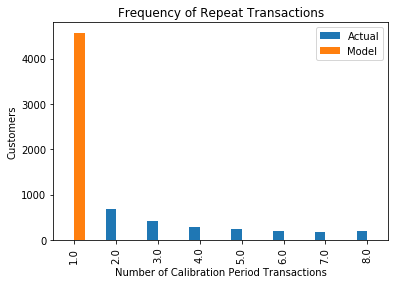

In [26]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)